# Classification of 1551 Requests

In [2]:
import os
import time
import re
import pickle
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm_notebook as progress
try:
    from cfuzzyset import cFuzzySet as FuzzySet
except ImportError:
    from fuzzyset import FuzzySet
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
import matplotlib as mpl

import langdetect
import tokenize_uk
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
import torch

In [3]:
download_data = False
download_embeddings = False

if download_data:
    !bash download_data.sh

if download_embeddings:
    !bash download_embeddings.sh

In [4]:
load_from_file = True

# Load data

*I manually fixed the dataset a bit by removing two replies in `Перевірка-дозвільної-документації--демонтаж-воріт--огорожі--паркану--забору.txt` (the line starts with `Відповідь`) since we should analyse requets only.

In [5]:
class Dataset(object):
    """1551 dataset class.
        Args:
            root -- path to data directory
            
        Main attributes:
            train_inputs -- list of requests for training
            train_targets -- list of corresponding categories for training
            val_inputs -- list of requests for validation
            val_targets -- list of corresponding categories for validation
    """
    def __init__(self, root, load_processed=False):
        self.root = root
        self.filepaths = sorted(glob('{}/*.txt'.format(root)))
        classes = [os.path.splitext(os.path.split(fp)[1])[0] for fp in self.filepaths]
        self.class_to_idx = dict(zip(classes, range(len(classes))))  # classset
        if not load_processed:
            self.__load()
            self.__split(random_state=42)
        else:
            self.load_processed()
        
    def __load(self):
        self.inputs = []
        self.targets = []
        for cls in progress(sorted(self.class_to_idx.keys())):
            with open('{}/{}.txt'.format(self.root, cls)) as f:
                inputs = self.__parse('\n'.join(f.readlines()[1:]))
                targets = [self.class_to_idx[cls]] * len(inputs)
                self.inputs.extend(inputs)
                self.targets.extend(targets)
        self.inputs = np.array([doc.replace('\n','') for doc in self.inputs])
        self.targets = np.array(self.targets)
        print('Dataset loaded')
        print('{} requests'.format(self.__len__()))
        print('{} categories'.format(len(self.class_to_idx.keys())))
    
    def __parse(self, text):
        emptiness_filter = lambda request: request.replace('\n','')\
                                                  .replace('”', '')\
                                                  .replace(' ', '') != ''
        lang_filter = lambda request: langdetect.detect(request) == 'uk'
        return list(filter(lang_filter, filter(emptiness_filter, re.split(r'\n\d{7}\n', text))))
    
    def __len__(self):
        return len(self.inputs)
    
    def __split(self, random_state=None):
        train_indices, val_indices = train_test_split(np.arange(self.__len__()),
                                                      test_size=0.3,
                                                      random_state=random_state,
                                                      stratify=self.targets)
        self.train_inputs = self.inputs[train_indices]
        self.train_targets = self.targets[train_indices]
        
        self.val_inputs = self.inputs[val_indices]
        self.val_targets = self.targets[val_indices]
        
        print('Split into train ({}) and validation ({}) data'.format(len(self.train_inputs),
                                                                      len(self.val_inputs)))
        plt.subplot(1,2,1)
        plt.title('Train data category distribution')
        plt.hist(self.train_targets)
        plt.subplot(1,2,2)
        plt.title('Validation data category distribution')
        plt.hist(self.val_targets)
        plt.show()
        
    def save(self):
        with open('dataset.pkl', 'wb') as f:
            pickle.dump({'train_inputs': self.train_inputs,
                         'train_targets': self.train_targets,
                         'val_inputs': self.val_inputs,
                         'val_targets': self.val_targets}, f)
        
    def load_processed(self):
        with open('dataset.pkl', 'rb') as f:
            data = pickle.load(f)
        self.train_inputs = data['train_inputs']
        self.train_targets = data['train_targets']
        self.val_inputs = data['val_inputs']
        self.val_targets = data['val_targets']
        
        self.inputs = np.hstack((self.train_inputs, self.val_inputs))
        self.targets = np.hstack((self.train_targets, self.val_targets))
        
        print('Dataset loaded')
        print('{} requests'.format(self.__len__()))
        print('{} categories'.format(len(self.class_to_idx.keys())))
        print('Split into train ({}) and validation ({}) data'.format(len(self.train_inputs),
                                                                      len(self.val_inputs)))
        plt.subplot(1,2,1)
        plt.title('Train data category distribution')
        plt.hist(self.train_targets)
        plt.subplot(1,2,2)
        plt.title('Validation data category distribution')
        plt.hist(self.val_targets)
        plt.show()

Dataset loaded
61821 requests
188 categories
Split into train (43274) and validation (18547) data


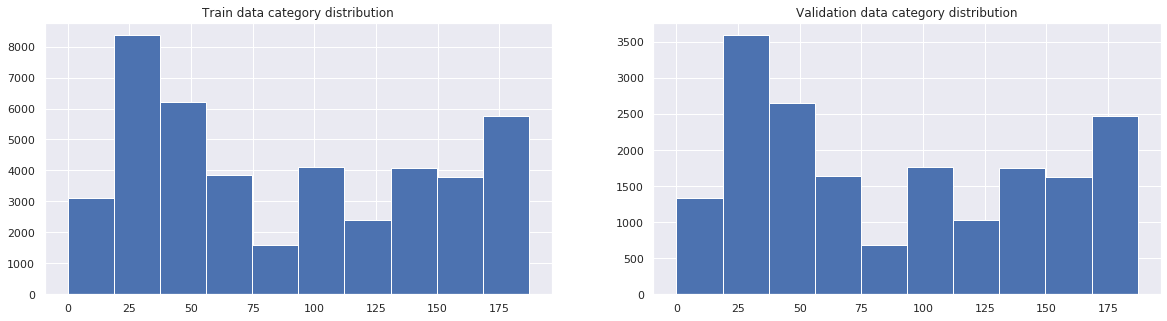

In [6]:
mpl.rcParams['figure.figsize'] = (20, 5)
dataset = Dataset(root='./data/1551', load_processed=load_from_file)

# Load embeddings

In [7]:
word2vec = KeyedVectors.load_word2vec_format('./embeddings/ubercorpus.lowercased.tokenized.word2vec.300d')

# Filter words, find the closest words in the word2vec vocabulary to fix mistaken words

In [8]:
stopwords_uk = ['до', 'на', 'за', 'його', 'і', 'в', 'що', 'він', 'щоб', 'мій', 'про',
                'небудь', 'ой', 'я', 'те', 'з', 'тим', 'як', 'все', 'вона', 'ти', 'своїй',
                'її', 'того', 'від', 'ще', 'ніби', 'ви', 'там', 'де', 'вони', 'т', 'ін', 'д',
                'тощо', 'куди', 'всіх', 'о', 'через', 'ми', 'твій', 'наш', 'ваш', 'є', 'бути']

if not load_from_file:
    w2v_vocab = FuzzySet(word2vec.vocab)
    word_to_idx = {}  # vocabulary of correct words
    word_fixes = {}  # vocabulary of mistaken words with fixes (fixed versions are stored in word_to_idx)

    print('Fixed words:')
    for doc in progress(dataset.inputs):
        tokens = tokenize_uk.tokenize_words(doc.replace('\n',''))
        for token in tokens:
            token = token.lower()
            parse = morph.parse(token)[0]
            if parse.tag.POS not in {'NUMR', 'NPRO', 'PREP', 'CONJ', 'PRCL'} and \
                   not 'UNKN' in parse.tag and \
                   not 'NUMB' in parse.tag and \
                   not 'PNCT' in parse.tag and \
                   not token.isdigit() and \
                   token not in stopwords_uk and \
                   parse.normal_form not in stopwords_uk:

                if token not in word2vec and token not in word_fixes:
                    candidate = w2v_vocab.get(token)
                    if candidate is not None and len(candidate) > 0:
                        word_fixes[token] = candidate[0][1]
#                         print(token, '->', word_fixes[token])
                        token = word_fixes[token]
                if token in word2vec and token not in word_to_idx:
                    word_to_idx[token] = len(word_to_idx)

        with open('word_to_idx.pkl', 'wb') as f:
            pickle.dump(word_to_idx, f)
        with open('word_fixes.pkl', 'wb') as f:
            pickle.dump(word_fixes, f)
        
else:
    with open('word_to_idx.pkl', 'rb') as f:
        word_to_idx = pickle.load(f)
    with open('word_fixes.pkl', 'rb') as f:
        word_fixes = pickle.load(f)

In [9]:
print(len(word_to_idx), 'words in vocabulary,', len(word_fixes), 'words were fixed:')
for word in list(word_fixes.keys())[:10]:
    print(word, '->', word_fixes[word])
print('...')

92215 words in vocabulary, 56053 words were fixed:
щебнем -> щебенем
господарськи -> господарський
об’єму -> об'єму
заасфальтоване -> заасфальтовано
асфальтуванню -> асфальтування
захаращує -> захаращують
демонтуйте -> демонструйте
шевченкiвського -> шевченківського
рахонок -> рахунок
приїнятих -> прийнятих
...


P.S. lots of mistakes in the input text..

In [10]:
if not load_from_file:
    word_embeddings = np.zeros((len(word_to_idx), word2vec.vector_size))

    for word in word_to_idx:
        if word in word2vec:
            word_embeddings[word_to_idx[word]] = word2vec[word]
        else:
            word_embeddings[word_to_idx[word]] = word2vec[word_fixes[word]]

    with open('word_embeddings.pkl', 'wb') as f:
        pickle.dump(word_embeddings, f)
else:
    with open('word_embeddings.pkl', 'rb') as f:
        word_embeddings = pickle.load(f)
        
word_embeddings = torch.tensor(word_embeddings, dtype=torch.float32)
print(word_embeddings.shape)

torch.Size([92215, 300])


In [11]:
def doc2tokens(doc):
    words = tokenize_uk.tokenize_words(doc)
    tokens = []
    for word in words:
        word = word.lower()
        if word in word_to_idx:
            tokens.append(word)
        elif word in word_fixes:
            tokens.append(word_fixes[word])
    return tokens

def doc2vec(doc, weights=None):
    words = tokenize_uk.tokenize_words(doc)
    vector = []
    for word in words:
        word = word.lower()
        if word in word_to_idx:
            vector.append(word_embeddings[word_to_idx[word]].numpy())
        elif word in word_fixes:
            vector.append(word_embeddings[word_to_idx[word_fixes[word]]].numpy())
    if len(vector) == 0:
        return np.zeros(word_embeddings.shape[1])
    if weights is None:
        weights = np.ones(len(vector))
    return np.average(vector, axis=0, weights=weights)

In [12]:
train_inputs_tokens = [doc2tokens(doc) for doc in progress(dataset.train_inputs)]
val_inputs_tokens = [doc2tokens(doc) for doc in progress(dataset.val_inputs)]
inputs_tokens = train_inputs_tokens + val_inputs_tokens

In [13]:
train_inputs_vec = [doc2vec(doc) for doc in progress(dataset.train_inputs)]
val_inputs_vec = np.stack([doc2vec(doc) for doc in progress(dataset.val_inputs)])
inputs_vec = np.vstack([train_inputs_vec, val_inputs_vec])

In [14]:
print('============================ Example ============================')
print(dataset.inputs[0])
print(inputs_tokens[0])
print(inputs_vec[0][:10], '...')

============================ Example ============================
Біля будинку за адресою Кіото 5 проводили ремонт труб , зробили велике  розриття асфальтового покриття . Після розриття  котловани засипали піском та щебнем, а великі ями ( біля 6-7 штук ) на дорожньому покритті на в”їзді та вздовж будинку не засипали.  Хоча було звернення 26 Серпня 2014  П-12431 по цьому питанню .  Чому відповідальні особи не підходять по-господарськи до вирішення проблеми?  Працювала  ж техніка, засипати 7 ям щебнем- це малий процент від того об’єму, який  був засипаний після розриття двору, але ніхто нічого не зробив. На сьогодні  розриття не заасфальтоване. Велике прохання виконати  ремонт дорожнього покриття  біля нашого будинку під час виконання робіт по асфальтуванню цого розриття.
['біля', 'будинку', 'адресою', 'кіото', 'проводили', 'ремонт', 'труб', 'зробили', 'велике', 'розриття', 'асфальтового', 'покриття', 'після', 'розриття', 'котловани', 'засипали', 'піском', 'щебенем', 'великі', 'ями', 'б

In [15]:
assert all([word in word_to_idx for sent in inputs_tokens for word in sent])
assert len(word_to_idx) == word_embeddings.shape[0]

# Classify

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import rnn

torch.manual_seed(1)
mpl.rcParams['figure.figsize'] = (30, 25)

## KNN

In [ ]:
knn = KNeighborsClassifier(metric='cosine')
knn.fit(train_inputs_vec, dataset.train_targets)
knn_val_predictions = knn.predict(val_inputs_vec)

knn_f1 = f1_score(dataset.val_targets, knn_val_predictions, average='micro')
knn_cm = confusion_matrix(dataset.val_targets, knn_val_predictions)

F1 score: 0.4063


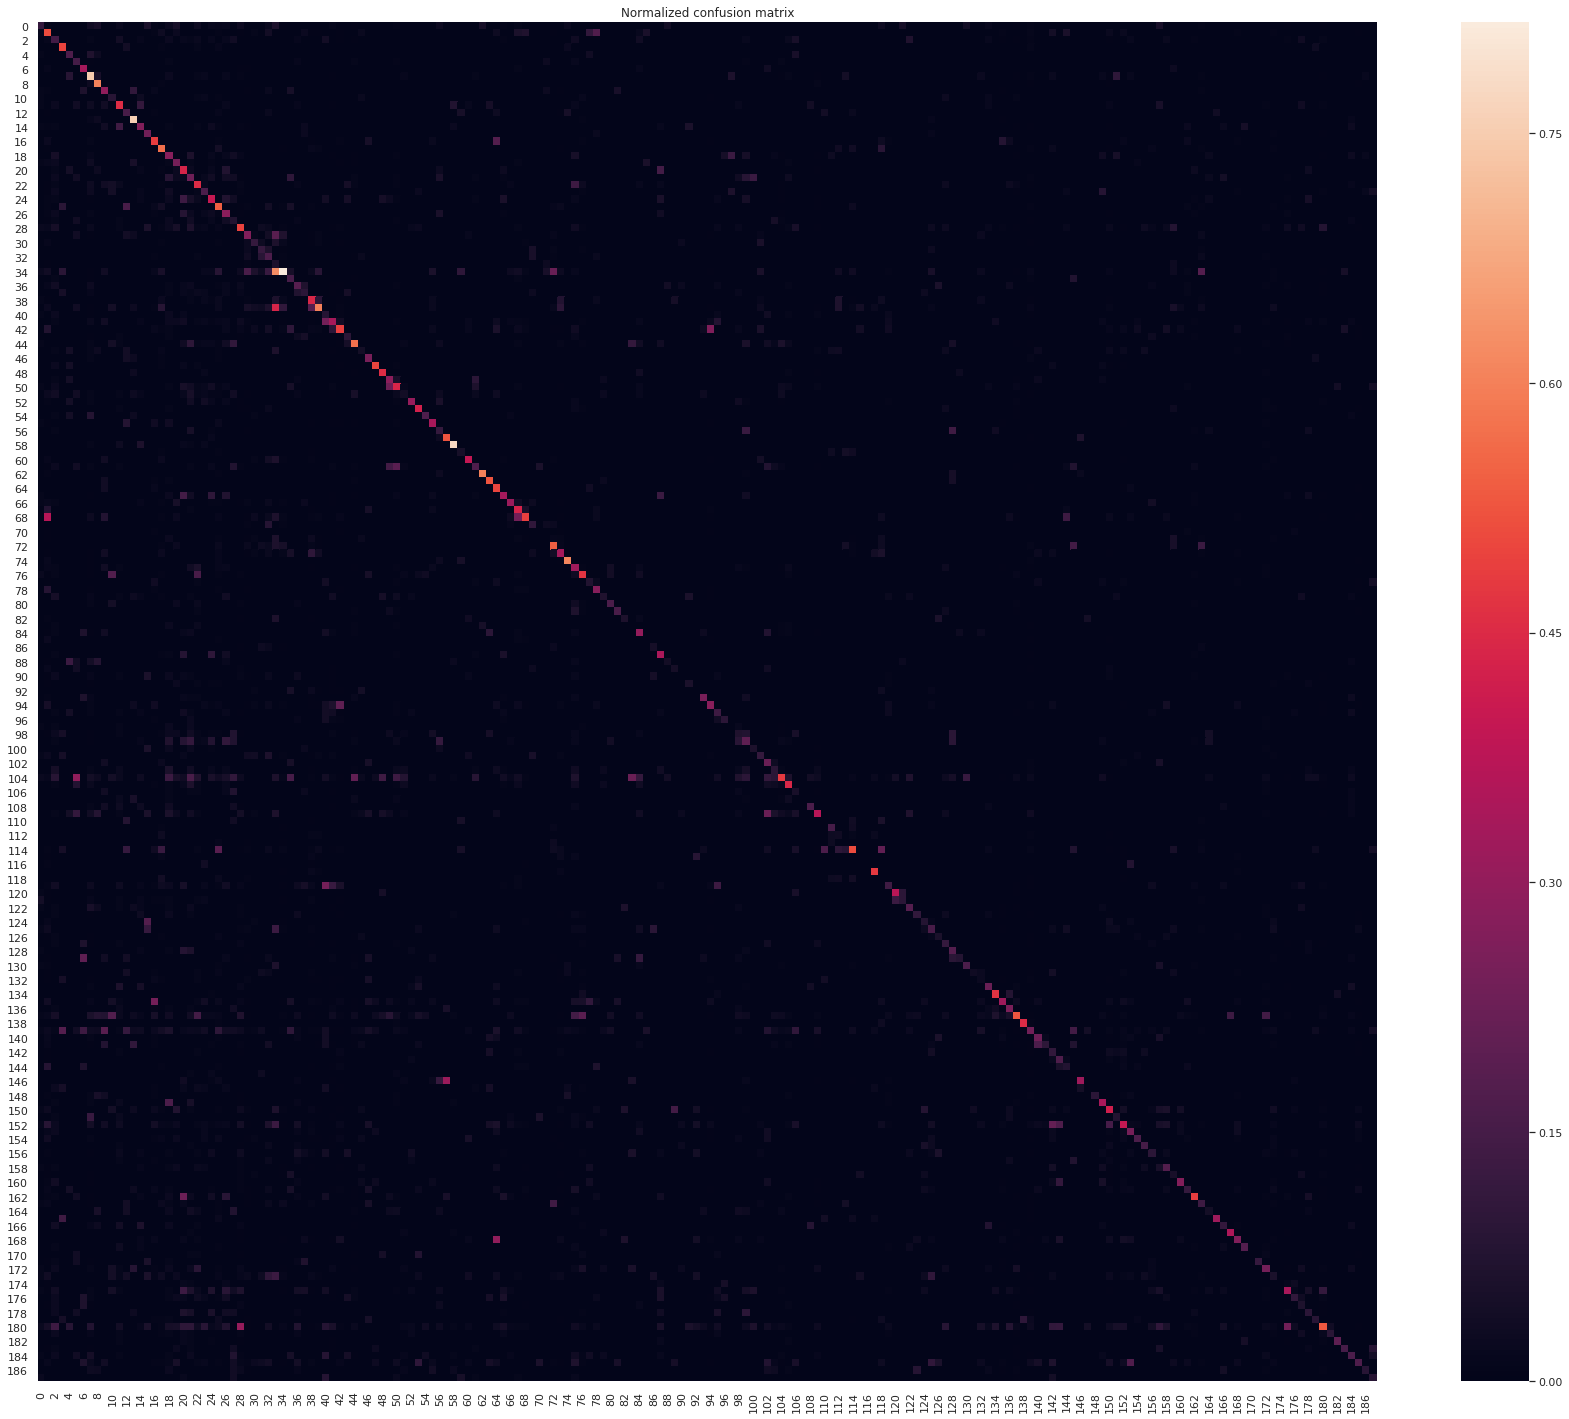

In [470]:
print('F1 score: {:.4f}'.format(knn_f1))
sns.heatmap(knn_cm / knn_cm.sum(1), annot=False)
plt.title('Normalized confusion matrix')
plt.show()

## Random Forest

In [323]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=25, random_state=42)
rf.fit(train_inputs_vec, dataset.train_targets)
rf_val_predictions = rf.predict(val_inputs_vec)

rf_f1 = f1_score(dataset.val_targets, rf_val_predictions, average='micro')
rf_cm = confusion_matrix(dataset.val_targets, rf_val_predictions)

F1 score: 0.2325


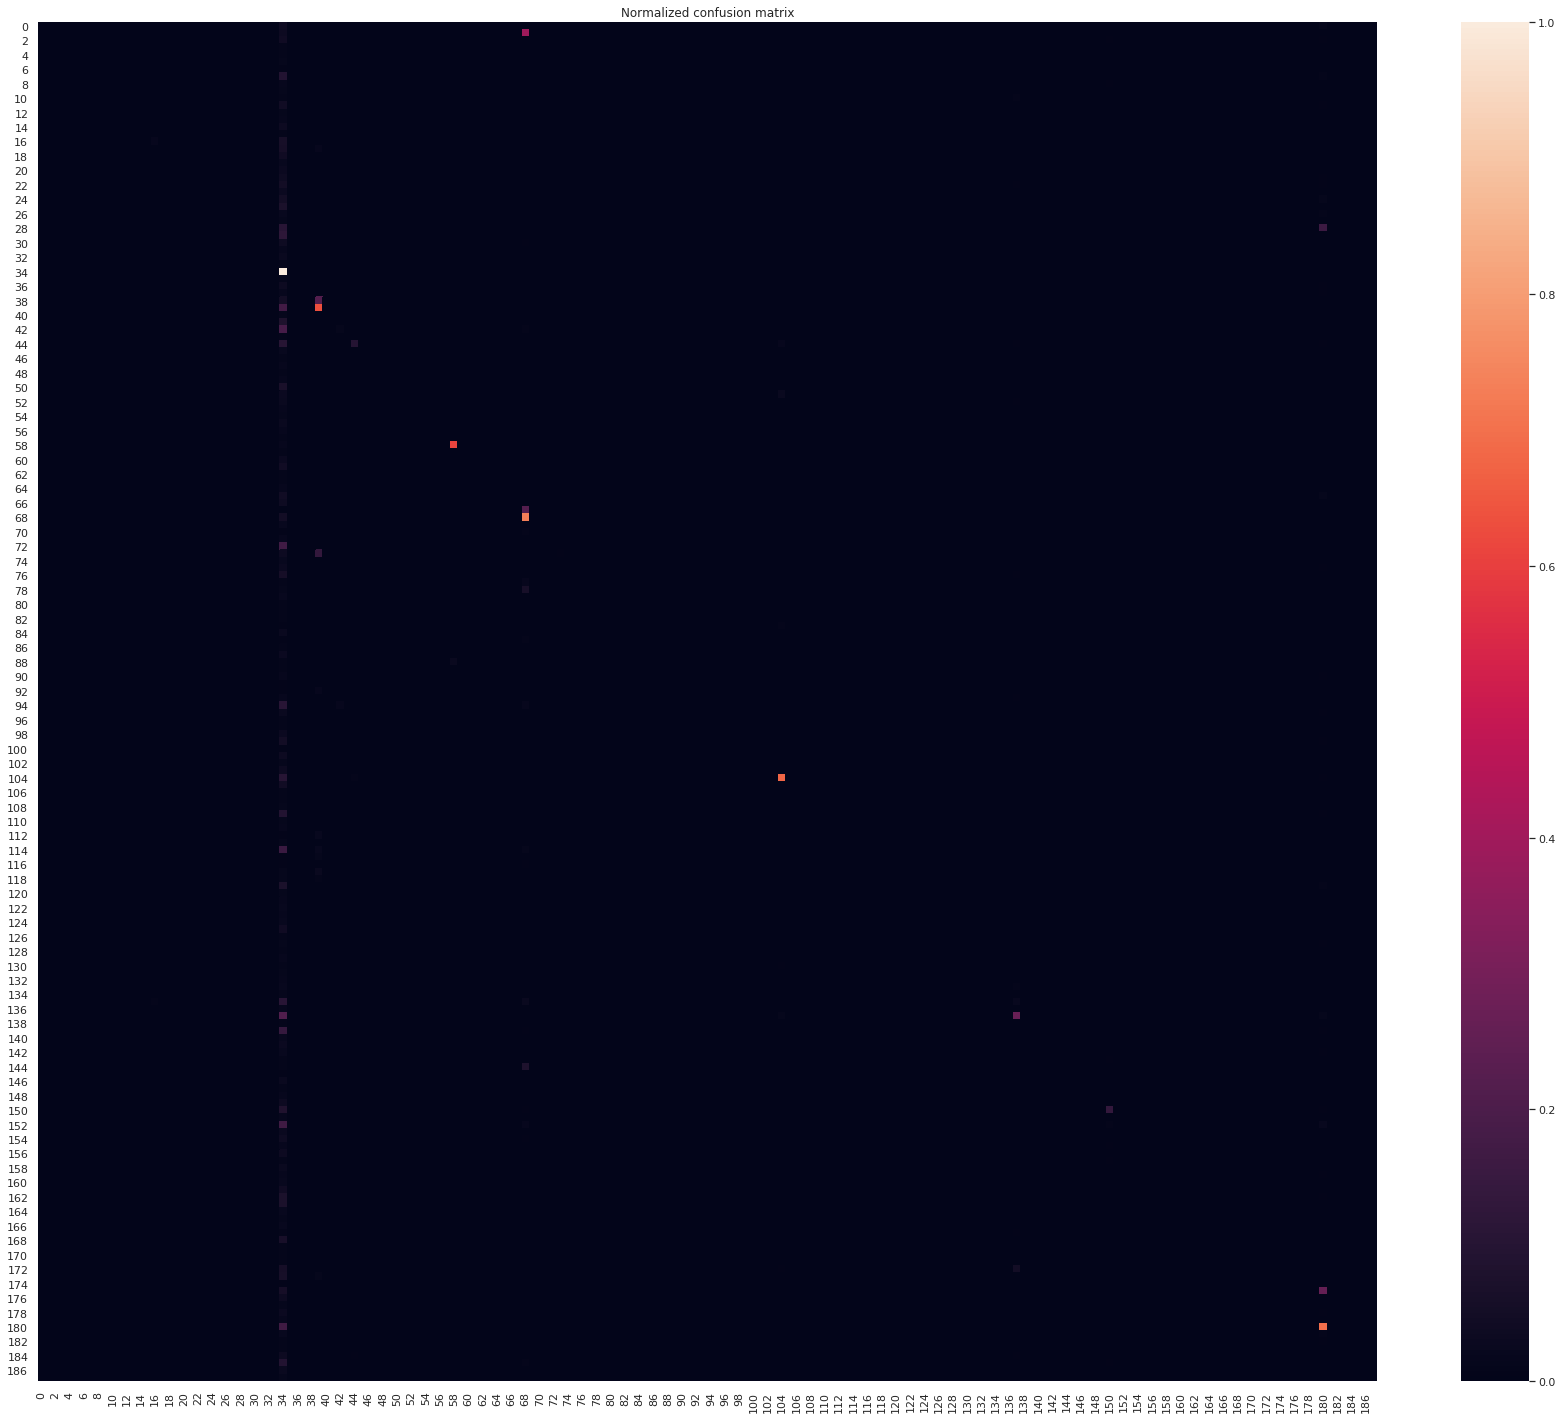

In [471]:
print('F1 score: {:.4f}'.format(rf_f1))
sns.heatmap(rf_cm / rf_cm.sum(1), annot=False)
plt.title('Normalized confusion matrix')
plt.show()

## MLP

In [321]:
mlp = MLPClassifier(hidden_layer_sizes=(256,128),
                    activation='relu',
                    solver='adam',
                    alpha=0.2,
                    learning_rate_init=0.1,
                    max_iter=50)

mlp.fit(train_inputs_vec, dataset.train_targets)
mlp_val_predictions = mlp.predict(val_inputs_vec)

mlp_f1 = f1_score(dataset.val_targets, mlp_val_predictions, average='micro')
mlp_cm = confusion_matrix(dataset.val_targets, mlp_val_predictions)

F1 score: 0.2891


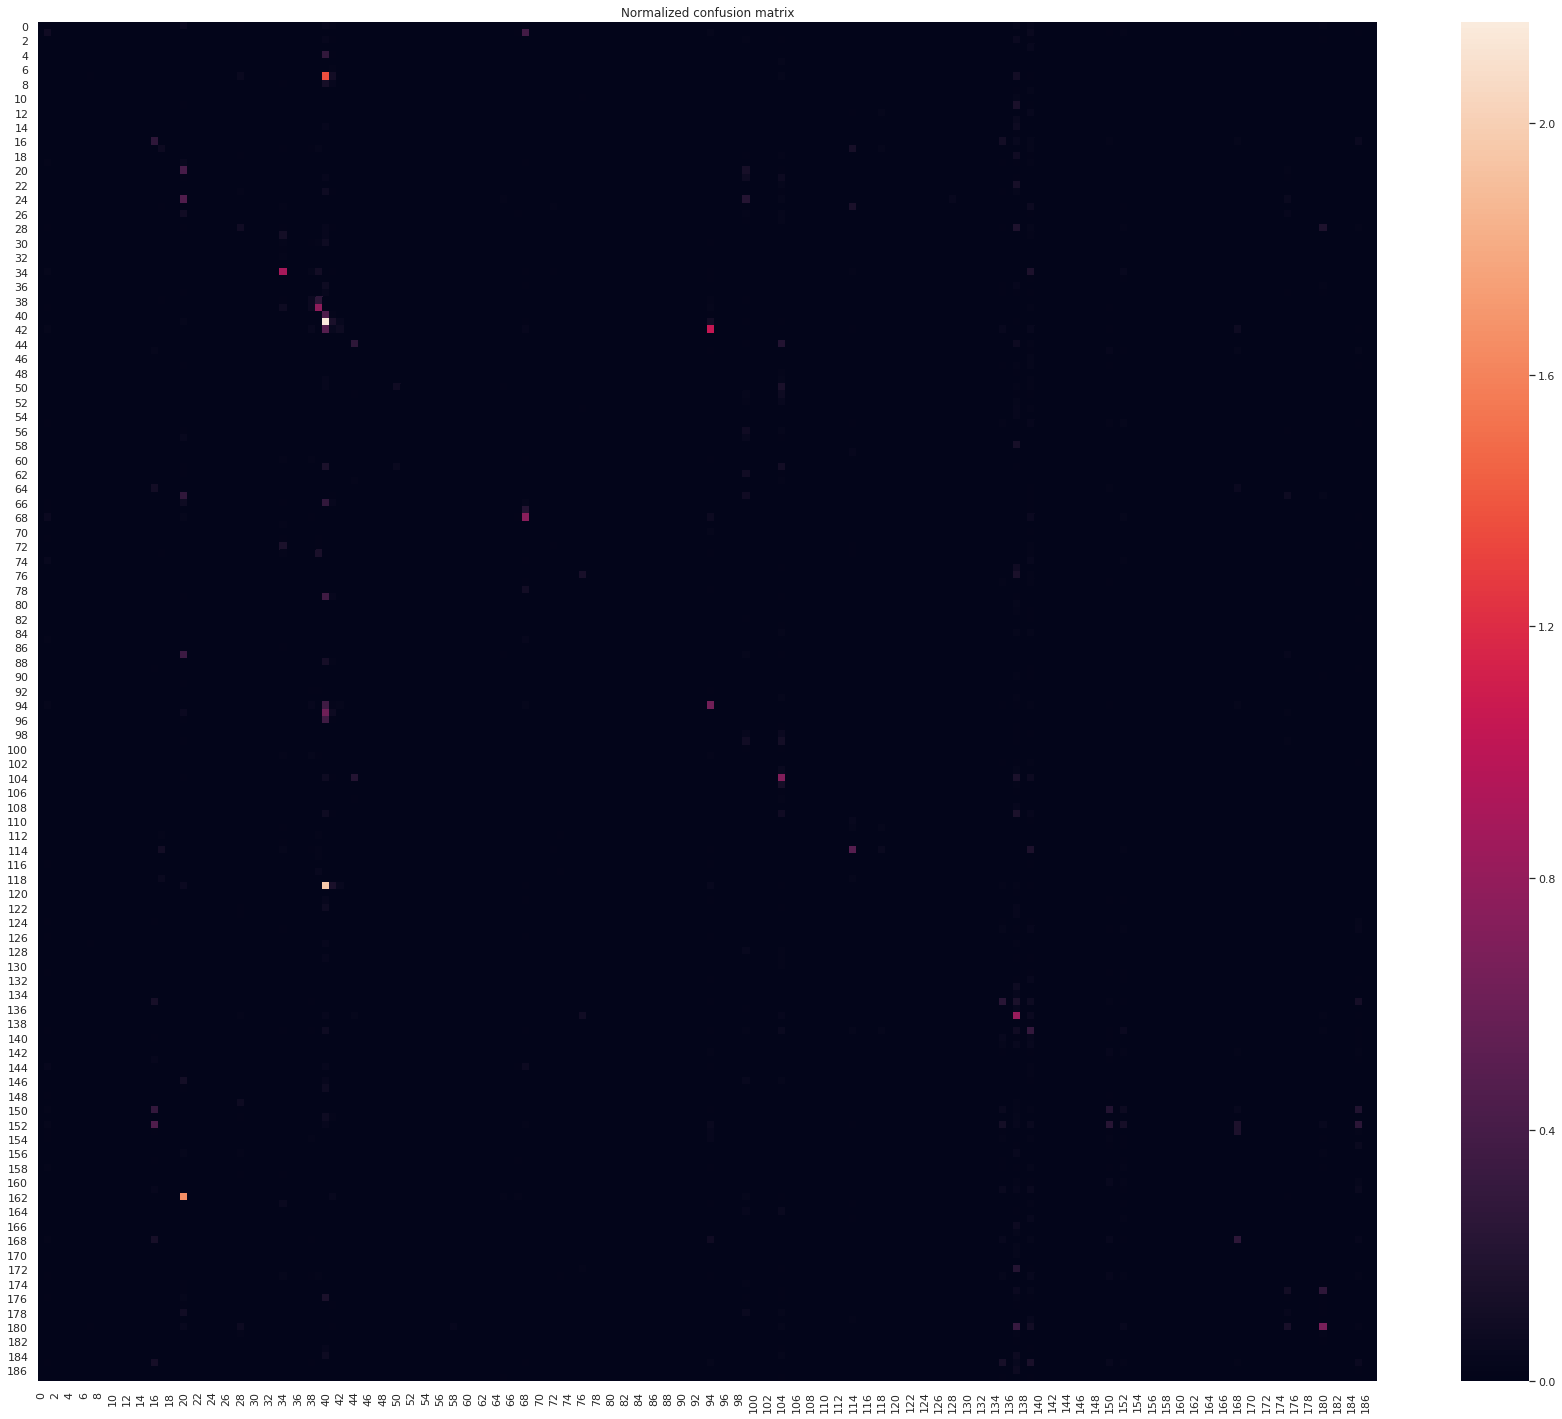

In [472]:
print('F1 score: {:.4f}'.format(mlp_f1))
sns.heatmap(mlp_cm / mlp_cm.sum(1), annot=False)
plt.title('Normalized confusion matrix')
plt.show()

# LSTM

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value
    """
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def seq_to_idxs(seq, mapping):
    """Converts a sequence of elements to sequence of indices
       using given mapping

    Args:
        seq -- list of elements
        mapping -- {element: idx} dict
    """
    outs_seq = [torch.tensor(mapping[el], dtype=torch.long) for el in seq]
    outs_seq = torch.stack(outs_seq, 0)
    return outs_seq

def calculate_scores(outputs, targets, num_classes, log=False):
    """Calculate per-class and micro-average precision, recall, F-1 score and F-0.5 score
    
        Args:
            outputs: tensor of log-softmax model outputs for the dataset
            targets: tensor of true class indices for the dataset
            log: whether to print or not
        Returns:
            (micro-average) precision, recall, F-1 score, F-0.5 score
    """    
    def F_score(precision, recall, beta=1):
        return (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 1e-15)

    pred = outputs.max(dim=1)[1]
    TP, TN = torch.zeros(num_classes), torch.zeros(num_classes)
    FP, FN = torch.zeros(num_classes), torch.zeros(num_classes)
    if log:
        print('Cls\tSize\tPrecision\tRecall\t\tF1\tF0.5')
    for i in range(num_classes):
        TP[i] = (pred[targets==i]==i).sum()
        TN[i] = (pred[targets!=i]!=i).sum()
        FP[i] = (pred[targets!=i]==i).sum()
        FN[i] = (pred[targets==i]!=i).sum()

        precision = float(TP[i] / (TP[i] + FP[i] + 1e-15))
        recall = float(TP[i] / (TP[i] + FN[i] + 1e-15))
        if log:
            print('{}\t{}\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t{:.4f}'.format(i, len(targets[targets==i]),
                                                                    precision, recall,
                                                                    F_score(precision, recall, beta=1),
                                                                    F_score(precision, recall, beta=0.5)))

    MicroAvePrecision = float(TP.sum() / (TP.sum() + FP.sum()))
    MicroAveRecall = float(TP.sum() / (TP.sum() + FN.sum()))
    F1 = F_score(MicroAvePrecision, MicroAveRecall, beta=1)
    F05 = F_score(MicroAvePrecision, MicroAveRecall, beta=0.5)
    if log:
        print('{}\t{}\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t{:.4f}'.format('MICRO', len(targets),
                                                                  MicroAvePrecision,
                                                                  MicroAveRecall,
                                                                  F1, F05))
    return MicroAvePrecision, MicroAveRecall, F1, F05

In [25]:
class LSTMClassifier(nn.Module):
    """
    Args:
        embedding_dim -- 300
        hidden_dim -- hidden state dimensionality
        vocab_size -- vocabulary size
        num_classes -- number of classes
        pretrained_embeddings -- None or [vocab_size, embedding_dim] tensor
    """
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes,
                 num_layers=2,
                 pretrained_embeddings=None, device='cpu'):

        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings,
                                                                freeze=True).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2,
                            num_layers=self.num_layers,
                            bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_dim*self.num_layers, self.num_classes)
        self.dropout = nn.Dropout(p=0.4)
        self.device = device
        self.to(self.device)

    def forward(self, inputs):
        embeds = rnn.PackedSequence(self.word_embeddings(inputs.data), inputs.batch_sizes)
        h0 = torch.randn(2*self.num_layers, inputs.batch_sizes[0], self.hidden_dim//2).to(self.device)
        c0 = torch.randn(2*self.num_layers, inputs.batch_sizes[0], self.hidden_dim//2).to(self.device)
        lstm_out, (hidden, cell) = self.lstm(embeds, (h0, c0))
        hidden = hidden.permute(1,0,2).contiguous().view(inputs.batch_sizes[0], -1)
        scores = F.log_softmax(self.cls(self.dropout(hidden)), dim=1)
        return scores

In [24]:
class Trainer():
    def __init__(self, model, loss_fn, optimizer, word_to_idx, device='cpu'):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.word_to_idx = word_to_idx
        self.device = device
    
    def fit(self, num_epochs,
            train_data, train_batch_size, val_data, val_batch_size,
            log_interval=50):
        for epoch in range(1, num_epochs+1):
            self.__train(epoch, train_data, train_batch_size, log_interval)
            self.__validate(epoch, val_data, val_batch_size)
        
    def __train(self, epoch, train_data, batch_size, log_interval=50):
        losses = AverageMeter()
        batch_time = AverageMeter()
        batch_start = 0
        batch_idx = 0
        while batch_start < len(train_data):
            end = time.time()
            self.optimizer.zero_grad()

            batch = train_data[batch_start:batch_start + batch_size]
            inputs_packed, targets_batch = self._prepare_batch(batch)
            inputs_packed = inputs_packed.to(self.device)
            targets_batch = targets_batch.to(self.device)
            outputs = self.model(inputs_packed)

            loss = self.loss_fn(outputs, targets_batch)
            loss.backward()
            self.optimizer.step()
            
            losses.update(loss.item())
            batch_time.update(time.time() - end)

            batch_start += batch_size
            batch_idx += 1
            
            if batch_idx % log_interval == 0:
                print('Train Epoch: {}\t[{:>5}/{:<5}]\tTime: {:.2f} ({:.2f})\tLoss: {:.4f} ({:.4f})'.format(epoch,
                    min(batch_start, len(train_data)), len(train_data),
                    batch_time.val, batch_time.avg,
                    losses.val, losses.avg))
        print('====> Train. {}\tTotal time: {:.2f}\tAverage loss: {:.4f}'.format(
              epoch, batch_time.sum, losses.avg))
            
            
    def __validate(self, epoch, val_data, batch_size):
        losses = AverageMeter()
        batch_time = AverageMeter()
        F1scores = AverageMeter()
        with torch.no_grad():
            batch_start = 0
            batch_idx = 0
            while batch_start < len(val_data):
                end = time.time()

                batch = val_data[batch_start:batch_start + batch_size]
                inputs_packed, targets_batch = self._prepare_batch(batch)
                inputs_packed = inputs_packed.to(self.device)
                targets_batch = targets_batch.to(self.device)
                outputs = self.model(inputs_packed)
                
                loss = self.loss_fn(outputs, targets_batch)
                _, _, F1, _ = calculate_scores(outputs, targets_batch, self.model.num_classes, log=False)
                F1scores.update(F1)

                losses.update(loss.item())
                batch_time.update(time.time() - end)

                batch_start += batch_size
                batch_idx += 1
        print('====> Valid. {}\tTotal time: {:.2f}\tAverage loss: {:.4f}\tF-1: {:.4f}\t'.format(
              epoch, batch_time.sum, losses.avg, F1scores.avg))
            
    def _prepare_batch(self, batch):
        inputs_batch = [seq_to_idxs(seq[0][:100], self.word_to_idx) for seq in batch]
        targets_batch = [seq[1] for seq in batch]
        
        order = sorted(enumerate(inputs_batch), key=lambda x: len(x[1]), reverse=True)
        inputs_batch = [inputs_batch[order_[0]] for order_ in order]
        targets_batch = torch.tensor([targets_batch[order_[0]] for order_ in order])

        inputs_packed = rnn.pack_sequence(inputs_batch)
        return inputs_packed, targets_batch
    
    def test(self, test_data):
        with torch.no_grad():
            inputs_packed, targets_batch = self._prepare_batch(test_data)
            inputs_packed = inputs_packed.to(self.device)
            targets_batch = targets_batch.to(self.device)
            outputs = self.model(inputs_packed)
        calculate_scores(outputs, targets_batch, self.model.num_classes, log=True);

In [26]:
train_data = list(zip(train_inputs_tokens, dataset.train_targets))
val_data = list(zip(val_inputs_tokens, dataset.val_targets))

hidden_dim = 128
learning_rate = 0.01

vocab_size = len(word_to_idx)
num_classes = len(dataset.class_to_idx)
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

model = LSTMClassifier(embedding_dim=word_embeddings.shape[1],
                       hidden_dim=hidden_dim,
                       vocab_size=vocab_size,
                       num_classes=num_classes,
                       pretrained_embeddings=word_embeddings,
                       device=device)
loss_function = nn.NLLLoss()
# loss_function = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=0.01)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_batch_size = 256
val_batch_size = 256

trainer = Trainer(model, loss_function, optimizer, word_to_idx, device=device)
trainer.fit(20, train_data, train_batch_size, val_data, val_batch_size)

Train Epoch: 1	[12800/43274]	Time: 0.06 (0.05)	Loss: 3.1235 (3.7410)
Train Epoch: 1	[25600/43274]	Time: 0.06 (0.05)	Loss: 2.6124 (3.3123)
Train Epoch: 1	[38400/43274]	Time: 0.05 (0.05)	Loss: 2.2321 (3.0464)
====> Train. 1	Total time: 9.04	Average loss: 2.9691
====> Valid. 1	Total time: 9.44	Average loss: 2.3119	F-1: 0.4234	
Train Epoch: 2	[12800/43274]	Time: 0.06 (0.06)	Loss: 2.0805 (2.1823)
Train Epoch: 2	[25600/43274]	Time: 0.06 (0.06)	Loss: 1.8927 (2.1029)
Train Epoch: 2	[38400/43274]	Time: 0.06 (0.06)	Loss: 1.6391 (2.0201)
====> Train. 2	Total time: 9.96	Average loss: 1.9900
====> Valid. 2	Total time: 9.15	Average loss: 1.8787	F-1: 0.5145	
Train Epoch: 3	[12800/43274]	Time: 0.06 (0.06)	Loss: 1.7421 (1.7319)
Train Epoch: 3	[25600/43274]	Time: 0.06 (0.06)	Loss: 1.6613 (1.7059)
Train Epoch: 3	[38400/43274]	Time: 0.06 (0.06)	Loss: 1.4784 (1.6685)
====> Train. 3	Total time: 9.89	Average loss: 1.6490
====> Valid. 3	Total time: 9.23	Average loss: 1.7403	F-1: 0.5431	
Train Epoch: 4	[12800/

In [54]:
trainer.device = 'cpu'
trainer.model.device = 'cpu'
trainer.model.to('cpu')
trainer.test(val_data)

Cls	Size	Precision	Recall		F1	F0.5
0	92	0.4674		0.4674		0.4674	0.4674
1	209	0.4290		0.6938		0.5302	0.4644
2	84	0.1532		0.2024		0.1744	0.1610
3	22	0.8889		0.7273		0.8000	0.8511
4	24	0.3077		0.1667		0.2162	0.2632
5	27	0.4688		0.5556		0.5085	0.4839
6	15	0.2500		0.1333		0.1739	0.2128
7	190	0.6222		0.7368		0.6747	0.6422
8	38	0.5862		0.4474		0.5075	0.5519
9	27	0.1250		0.0741		0.0930	0.1099
10	23	0.2414		0.3043		0.2692	0.2518
11	97	0.5115		0.6907		0.5877	0.5395
12	26	0.2941		0.1923		0.2326	0.2660
13	37	0.8529		0.7838		0.8169	0.8382
14	64	0.5152		0.2656		0.3505	0.4337
15	17	0.4545		0.2941		0.3571	0.4098
16	121	0.6434		0.6860		0.6640	0.6515
17	130	0.7385		0.7385		0.7385	0.7385
18	87	0.3551		0.4368		0.3918	0.3689
19	41	0.5185		0.6829		0.5895	0.5447
20	62	0.6296		0.5484		0.5862	0.6115
21	82	0.2347		0.2805		0.2556	0.2426
22	104	0.5194		0.6442		0.5751	0.5403
23	56	0.6667		0.6786		0.6726	0.6690
24	108	0.5758		0.7037		0.6333	0.5975
25	144	0.6778		0.8472		0.7531	0.7060
26	56	0.6226		0.5893		0.6055	0.6

> So, the best performance I got with BiLSTM: F1 score 0.5857